In [13]:
# Як змінюється середній відсоток чайових залежно від діапазонів загальної вартості поїздки, та скільки записів припадає на кожен з цих діапазонів?

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pandas as pd


In [14]:
spark = SparkSession.builder \
    .appName("TripDurationAnalysis") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

In [15]:
df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")


In [16]:

df = df_trip.join(df_fare, on=["medallion", "pickup_datetime"], how="inner")

df = df.withColumn("tip_percentage", (F.col("tip_amount") / F.col("total_amount")) * 100)

bins = [0, 10, 20, 30, 40, 50, 60, 100, float('inf')]  # Example ranges for total_amount
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-100', '100+']

df = df.withColumn(
    "total_amount_bin", 
    F.when(F.col("total_amount") <= 10, "0-10")
     .when((F.col("total_amount") > 10) & (F.col("total_amount") <= 20), "10-20")
     .when((F.col("total_amount") > 20) & (F.col("total_amount") <= 30), "20-30")
     .when((F.col("total_amount") > 30) & (F.col("total_amount") <= 40), "30-40")
     .when((F.col("total_amount") > 40) & (F.col("total_amount") <= 50), "40-50")
     .when((F.col("total_amount") > 50) & (F.col("total_amount") <= 60), "50-60")
     .when((F.col("total_amount") > 60) & (F.col("total_amount") <= 100), "60-100")
     .otherwise("100+")
)

df_grouped = df.groupBy("total_amount_bin").agg(
    F.avg("tip_percentage").alias("avg_tip_percentage"),
    F.count("*").alias("count_records")
)

df_grouped_pd = df_grouped.toPandas()

df_grouped_pd["total_amount_bin"] = pd.Categorical(df_grouped_pd["total_amount_bin"], categories=labels, ordered=True)
df_grouped_pd = df_grouped_pd.sort_values("total_amount_bin")


/var/folders/vz/rgbmjfqn0nq0nvl3m3c5by_00000gn/T/ipykernel_31599/519572338.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped_pd, x="total_amount_bin", y="avg_tip_percentage", palette="viridis", ax=ax1)


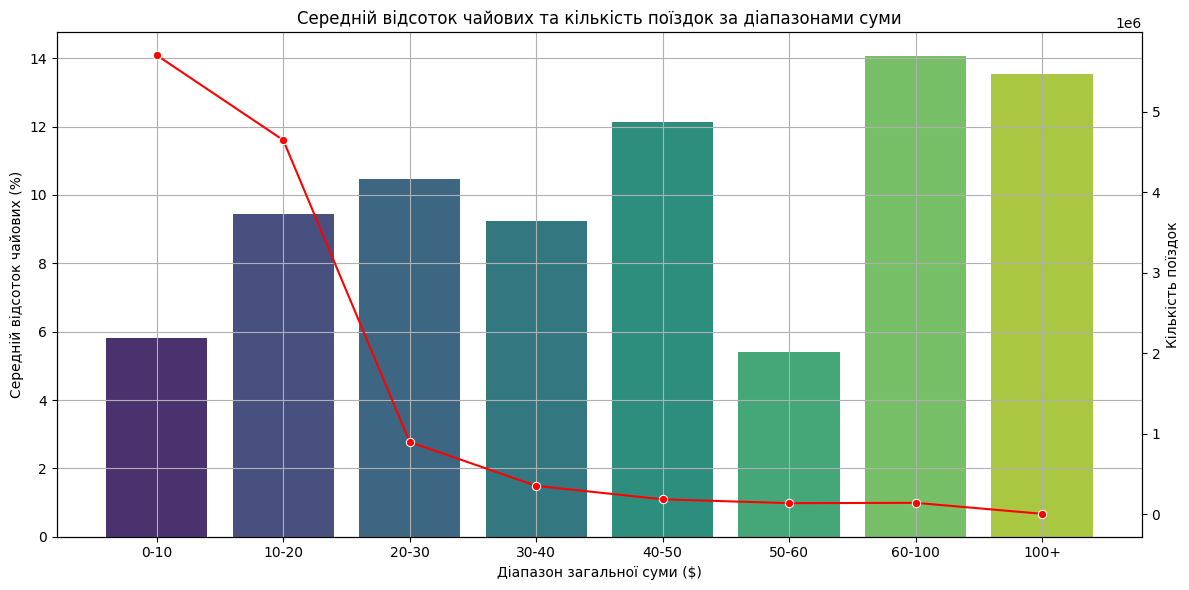

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=df_grouped_pd, x="total_amount_bin", y="avg_tip_percentage", palette="viridis", ax=ax1)

ax1.set_title("Середній відсоток чайових та кількість поїздок за діапазонами суми")
ax1.set_xlabel("Діапазон загальної суми ($)")
ax1.set_ylabel("Середній відсоток чайових (%)")

ax2 = ax1.twinx()
sns.lineplot(data=df_grouped_pd, x="total_amount_bin", y="count_records", marker="o", color="red", ax=ax2)

ax2.set_ylabel("Кількість поїздок")

ax1.grid(True)
plt.tight_layout()

plt.show()


In [19]:
df_grouped.coalesce(1).write.option("header", True).mode("overwrite").csv("/Users/mac/Development/nyc-taxi-spark-project/results/5.csv")